<a href="https://colab.research.google.com/github/Siri-cod/LLMcourse/blob/main/homework/04_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 4: LLM evaluation (59 points)
=====

The third homework zooms in on evaluating LLMs, specifically, on the following skills: using log probabilities of string under a trained LM to evaluate it, coming up with items to test particular aspets of LLMs, and comparing LLM measures to measures of human performance.

### Logistics

* submission deadline: July 15th th 23:59 German time via Moodle
  * please upload a **SINGLE .IPYNB FILE named Surname_FirstName_HW4.ipynb** containing your solutions of the homework. Make sure that your **plots** for the last exercise are either rendered in the notebook or submitted together with it in a zip file.
* please solve and submit the homework **individually**!
* if you use Colab, to speed up the execution of the code on Colab, you can use the available GPU (if Colab resources allow). For that, before executing your code, navigate to Runtime > Change runtime type > GPU > Save.

**NOTE:** It might be that, on Colab, you run out of memory between the exercises. You might need to restart the runtime / it will restart automatically. After the restart, you might need to re-install packages. Furthermore, if you work on Colab, do not leave working on these tasks to the last minute, as Colab sometimes limits access to GPU runtime / day if one tries to restart access GPUs frequently.

## Exercise 1: Understanding grammatical capabilities of LLMs (10 points)

In this task, we look at [BLiMP](https://aclanthology.org/2020.tacl-1.25/), the benchmark of linguistic minimal pairs. This is a well-known benchmark for evaluating linguistic capabilities of language models. It consists of 67 individual datasets, each containing 1,000 minimal pairs -- that is, pairs of minimally different sentences that contrast in grammatical acceptability and isolate specific phenomenon in syntax, morphology, or semantics. The authors suggest to use the benchmark to evaluate LMs by observing whether they assign a higher probability to the acceptable sentence in each minimal pair.

> Your task is to evaluate an open-source model, [Olmo-2-1B-Instruct](https://huggingface.co/allenai/OLMo-2-0425-1B-Instruct), on this benchmark by completing the code below. Based on your evaluation results, please answer the following questions.
> Please use the following test suites to answer them: anaphor_gender_agreement, determiner_noun_agreement_with_adjective_1, animate_subject_passive, complex_NP_island, npi_present_1, superlative_quantifiers_1, existential_there_object_raising, principle_A_case_1.
>
> The entire benchmark can be found [here](https://huggingface.co/datasets/nyu-mll/blimp).
>
> 1. Plot the accuracy of the model on the different grammatical phenomena, represented in different test suites.
> 2. Calculate the average accuracies and the confidence intervals in the different fields: syntax, morphology, syntax-semantics, semantics. Is the performance the same across the different fields? Which field is the most difficult one?
> 3. What is the easiest grammatical phenomenon, what is the most difficult grammatical phenomenon (as captured by the single test suites) for the model?

Note: you might be prompted to reload your runtime after installing minicons, and you might see some deprecation warnings / dependency incompatibilities when it is installed. Please ignore these warnings (usually not the best practice, we know!).

In [1]:
!pip install minicons datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [3]:
from datasets import load_dataset
import torch
from minicons import scorer
import numpy as np
import pandas as pd

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [2]:
pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [5]:
# iterate over the test suites

#### YOUR CODE HERE ####
test_suites = [
    "anaphor_gender_agreement",
    "determiner_noun_agreement_with_adjective_1",
    "animate_subject_passive",
    "complex_NP_island",
    "npi_present_1",
    "superlative_quantifiers_1",
    "existential_there_object_raising",
    "principle_A_case_1"
]

dataset = load_dataset("nyu-mll/blimp", "anaphor_gender_agreement")
# inspect the dataset
dataset["train"][0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'sentence_good': "Katherine can't help herself.",
 'sentence_bad': "Katherine can't help himself.",
 'field': 'morphology',
 'linguistics_term': 'anaphor_agreement',
 'UID': 'anaphor_gender_agreement',
 'simple_LM_method': True,
 'one_prefix_method': True,
 'two_prefix_method': False,
 'lexically_identical': False,
 'pair_id': 0}

In [6]:
# iterate over the single items of the test suite
# hint: you can use code similar to the one in sheet 7.1

# set up the model as a minicons scorer
lm_scorer = scorer.IncrementalLMScorer(
    "allenai/OLMo-2-0425-1B-Instruct",
    device=device,
)

# create some lists to store the results
### YOUR CODE HERE ###
results = {}
category_results = {}
categories = {
    "anaphor_gender_agreement": "syntax",
    "determiner_noun_agreement_with_adjective_1": "morphology",
    "animate_subject_passive": "syntax-semantics",
    "complex_NP_island": "syntax",
    "npi_present_1": "syntax-semantics",
    "superlative_quantifiers_1": "semantics",
    "existential_there_object_raising": "syntax-semantics",
    "principle_A_case_1": "syntax"
}

for suite in test_suites:
    dataset = load_dataset("nyu-mll/blimp", suite)
    correct = []

    for item in dataset["train"]:
        # get the sentence pair
        sent_good = item['sentence_good']
        sent_bad = item['sentence_bad']

        # compare the sentences as suggested in the task description
        score_good = lm_scorer.sequence_score(sent_good)
        score_bad = lm_scorer.sequence_score(sent_bad)

        correct.append(score_good > score_bad)

    acc = np.mean(correct)
    results[suite] = acc

    # save to the category list
    cat = categories[suite]
    if cat not in category_results:
        category_results[cat] = []
    category_results[cat].extend(correct)

#for item in dataset["train"]:
    # get the sentence pair
    ### YOUR CODE HERE ###

    # compare the sentences as suggested in the task description
    ### YOUR CODE HERE ###

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/55.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/47.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/78.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/48.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/76.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

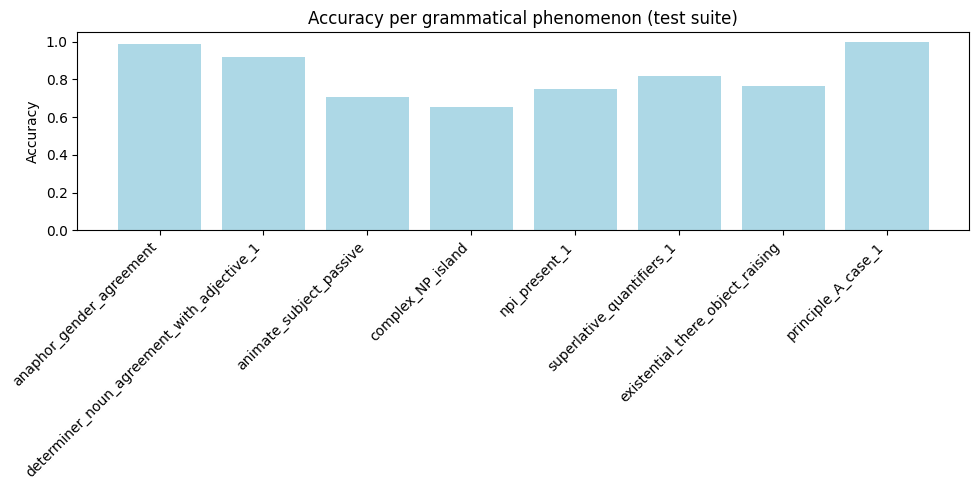

In [7]:
# calculate the performance by test suite
### YOUR CODE HERE ###
# plot the results in a bar plot
### YOUR CODE HERE ###
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color="lightblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy per grammatical phenomenon (test suite)")
plt.tight_layout()
plt.show()

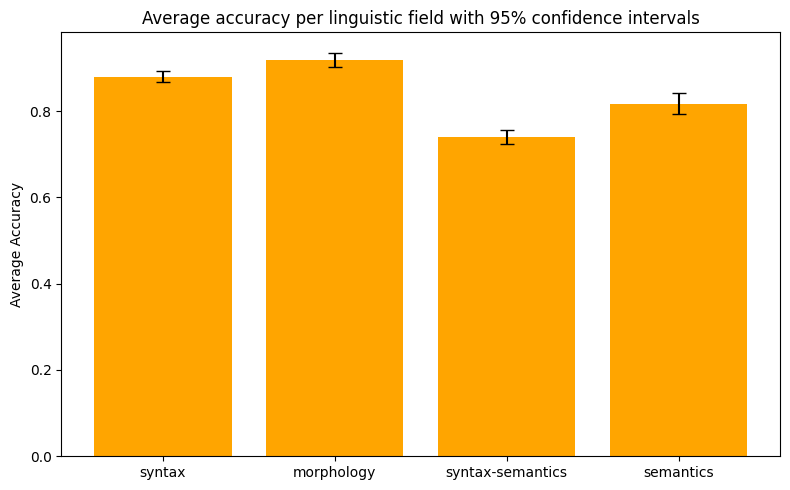

In [9]:
# calculate the performance as described above by category and plot the results in a bar plot with CIs
### YOUR CODE HERE ###
import scipy.stats as stats

avg_accs = {}
cis = {}

for cat, outcomes in category_results.items():
    acc = np.mean(outcomes)
    avg_accs[cat] = acc
    ci = stats.t.interval(
        0.95,
        len(outcomes)-1,
        loc=acc,
        scale=stats.sem(outcomes)
    )
    cis[cat] = ci

# plot bar plot with confidence intervals
plt.figure(figsize=(8, 5))
plt.bar(avg_accs.keys(), avg_accs.values(), yerr=[(top - avg_accs[k]) for k, (bot, top) in cis.items()], capsize=5, color="orange")
plt.ylabel("Average Accuracy")
plt.title("Average accuracy per linguistic field with 95% confidence intervals")
plt.tight_layout()
plt.show()

In [10]:
# identify easiest and hardest test suites
easiest = max(results, key=results.get)
hardest = min(results, key=results.get)

print(f"Easiest phenomenon: {easiest} ({results[easiest]:.2%})")
print(f"Hardest phenomenon: {hardest} ({results[hardest]:.2%})")

Easiest phenomenon: principle_A_case_1 (100.00%)
Hardest phenomenon: complex_NP_island (65.30%)


## Exercise 2: Evaluating societal biases (13 points)

In this exercise, we will consider aspects of LLM performance which may have social implications and that are deeply interconnected with how humans use language. This task evaluates whether LLMs overrepresent certain cultures over others, which could be due to, e.g., imbalances over training data sources and languages.

> Specifically, your task is to come up with an appropriate test item and evaluate whether LLMs exhibit certain cultural biases.
> In this task, you have to construct your own multiple-choice test item for investigating cultural biases of LLMs, where, given a context, the different available response / continuation options would reflect preferences for responses typical for different cultures.
> For instance, one response could be more acceptable under one particular cultural lens and another response under a different cultural background.
> Your task is then to evaluate the performance of two LLMs: the mostly monolingual `gpt2-large` and the multilingual `bigscience/bloom-560m` model. The second part of the task is to complete the evaluation code and interpret the results by answering the question below.
> Note that there obviously is no signle right answer to this, so we will assess the plausibility of your idea and the correctness of the code & interpretation.

Here is a simple example of a test item. More explanations are in parentheses. You should provide analogous explanations in the answers to the questions below, but do not pass these to the LLMs during evaluations.


Context 1: You are at a German supermarket. You walk up to the cashier and greet them by saying:

Context 2: You are at an American supermarket. You walk up to the cashier and greet them by saying:

A. Hello. (intuititvely, more likely in to be appropiate in the Germany context condition)

B. Bye. (a generally inappropriate response)

C. Hello, how are you? (intuitively, more likely to be appropriate in the US context condition; people usually don’t ask strangers ‘how are you’ in Germany)

I would say: (insert each of the answer options separately here and calculate their log probability, given each of the contexts).


For reference about constructing datasets and inspiration, feel free to take a look at the [ETHICS dataset](https://arxiv.org/pdf/2008.02275), e.g., Fig. 2, where the authors came up with different continuations tapping into different conditions, given a context.

> **Fill in your responses below.**
>
> 1. Your prompt (context 1 and 2, response options A-C; with explanations of the intuitive differences for each response option in respective cultural contexts):
> 2. Your model log probabilities (please fill in the table below with the conditional log probabilities you retrieved with the code below for your respective item):
>
| Context / Option | GPT-2 | Bloom |
|------------------|-------|-------|
| context 1 + A      | ...   | ...   |
| context 2 + A          |       |       |
| context 1 + B      |       |       |
| context 2 + B          |       |       |
| context 1 + C         |       |       |
| context 2 + C         |       |       |

> 3. Do the models show a preference for a particular cultural setting (context 1 or context 2)? Is there evidence for whether cultural biases might be caused by training data?
> 4. Are there aspects of the prompt that might influence your results? Please provide a brief justification / example why (not). Write 2 sentences max.

In [ ]:
from minicons import scorer
import pandas as pd

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

In [ ]:
# here is some starter code; please fill in your code / comments where it says #### YOUR CODE / COMMENT HERE ####

# set up a scorer
gpt2_scorer = scorer.IncrementalLMScorer(
    ### YOUR CODE HERE ###
)

bloom_scorer = scorer.IncrementalLMScorer(
    ### YOUR CODE HERE ###
)
# initialize list for storing the predictions
gpt2_predictions = []
bloom_predictions = []
answer_keys = ["ger", "nonsense", "us"]

# iterate over contexts
for context in range(### YOUR CODE HERE ###):
    # format / provide  the possible answer options from your vignette
    answer_options = ### YOUR CODE HERE ###
    # pass a list of contexts and a list of continuations to be scored
    answer_scores_gpt2 = gpt2_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
        ### YOUR CODE HERE ###,
    )
    answer_scores_bloom = bloom_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
        ### YOUR CODE HERE ###,
    )

    # check / inspect which answer has the highest score and which answer type (i.e., "culture") it corresponds to
    ### YOUR CODE / COMMENT HERE ###

## Exercise 3: Theory of mind evaluations of LLMs (14 points)

One capability that has been much debated in the context oflanguage models is so-called *theory-of-mind* (ToM) reasoning, a capability to reason about other people's latent mental states like beliefs and knowledge and how they influence the person's behavior.

One well-known task to investigate theory of mind capabilities is the so-called False Belief task.
We will use a benchmark [BigToM](https://arxiv.org/abs/2306.15448) that contains items with variations of this task generated trough LMs, specifically a subset of the forward and backward belief conditions.
Please download the relevant data [here](https://github.com/CogSciPrag/Understanding-LLMs-course/tree/main/understanding-llms/homework/data/bigtom.csv).

> Your task here is to:
>
> 1. Take a look at the paper to familiarize yourself with the benchmark. In max. two sentences per condition, explain what the forward and backward belief conditions of the benchmark test.
> 2. Complete the following code to evaluate the Olmo model from exercise 1 on the ToM benchmark (fill in the slots with ###YOUR CODE / COMMENT HERE ###). Specifically:
>
>   a. Evaluate the performance of the model when scoring the linguistic continuations of the sentence and comparing the respective conditional log probabilities. Compare the performance of the model in the false belief and the true belief conditions.
>
>   b. Evaluate the performance of the model when formatting the prompt in a multiple choice format, where the two continuations for each prompt are included in the prompt along with labels (e.g., A., B.). Then, let the model generate a few tokens and check if the correct answer label was predicted. . Compare the performance of the model in the false belief and the true belief conditions.
>
>   c. Does the model perform better under one of the evaluating approaches? Is it similar across true and false beliefs?

In [ ]:
# note: only load the model again if you are in a different runtime than when you solved exercise 1
# lm_scorer = scorer.IncrementalLMScorer(
    # "allenai/OLMo-2-0425-1B-Instruct",
    # device
# )

In [ ]:
# read the data (Note: you have to upload the file to your session in colab)
tom_back = pd.read_csv("data/bigtom.csv")

# inspect the data and construct the evaluation prompts for standard scoring of sentence completions
tom_back["prompt_tb"] = #### YOUR CODE HERE ####
tom_back["prompt_fb"] = #### YOUR CODE HERE ####

# calculate the scores of the true belief condition with the true continuations
tb_scores_true = lm_scorer.conditional_score(
    # format the prompt into a list of same length as the number of answer options
    tom_back["prompt_tb"].tolist(),
    #### YOUR CODE HERE ####
)
# calculate the scores of the true belief condition with the false continuations
tb_scores_false = lm_scorer.conditional_score(
    tom_back["prompt_tb"].tolist(),
    #### YOUR CODE HERE ####
)

# calculate the accuracy of the true belief condition
#### YOUR CODE HERE ####
print("True belief accuracy main ", tb_accuracy.mean())

# calculate the scores of the false belief condition with the true continuations
fb_scores_true = lm_scorer.conditional_score(
    ### YOUR CODE HERE ###,

)
# calculate the scores of the false belief condition with the false continuations
fb_scores_false = lm_scorer.conditional_score(
    #### YOUR CODE HERE ####
)
# calculate the accuracy of the false belief condition
#### YOUR CODE HERE ####
print("False belief accuracy main ", fb_accuracy.mean())

In [ ]:
# create the prompt for the multiple choice condition
def create_forced_choice_prompt(row):
    """
    Construct a prompt with the story, the trigger sentence,
    the task to choose the correct continuation for the the final sentence prefix,
    and the two continuations appended to the labels A, B.
    The order of the continuations is shuffled.

    Input:
    ------
    row: pandas Series
        Contains the story, trigger sentences, final sentence prefix, and continuations

    Returns:
    ------
    prompt_forced_choice_tb: str
        Forced choice prompt for true belief condition
    prompt_forced_choice_fb: str
        Forced choice prompt for false belief condition
    correct_label_tb: str
        Correct label for the correct true belief continuation (either "A" or "B", depending on the shuffling of the order of continuations)
    correct_label_fb: str
        Correct label for the correct false belief continuation (either "A" or "B", depending on the shuffling of the order of continuations)
    """
    # shuffle the order of the true and false continuations for both conditions

    tb_order = np.random.choice(["tb_correct_continuation", "fb_correct_continuation"], replace=False, size=2).tolist()
    fb_order = np.random.choice(["tb_correct_continuation", "fb_correct_continuation"], replace=False, size=2).tolist()
    task = " Choose the correct continuation for the following sentence: "
    # create the prompt for the forced choice task
    prompt_forced_choice_tb = ### YOUR CODE HERE ###
    prompt_forced_choice_fb = ### YOUR CODE HERE ###
    # get the correct labels for the true and false belief conditions
    correct_label_tb = ["A", "B"][### YOUR CODE HERE ###]
    correct_label_fb = ["A", "B"][### YOUR CODE HERE ###]
    return prompt_forced_choice_tb, prompt_forced_choice_fb, correct_label_tb, correct_label_fb


tom_fc_generation = tom_back.copy()

tom_fc_generation[[
    "prompt_forced_choice_tb",
    "prompt_forced_choice_fb",
    "correct_label_tb",
    "correct_label_fb"
]] = tom_back.apply(
    lambda row: create_forced_choice_prompt(row),
    axis=1,
    result_type="expand"
)

In [ ]:
# Now evaluate the forced choice condition with generation
free_generation_accuracy_tb = []
free_generation_accuracy_fb = []

# set up the generation pipeline

from transformers import pipeline
generation_pipeline = pipeline(
    "text-generation",
    model = lm_scorer.model,
    device=device,
    tokenizer=lm_scorer.tokenizer,
)

for i, r in tom_fc_generation.iterrows():
    # generate the continuation for the true belief condition
    pred = generation_pipeline(
        ### YOUR CODE HERE ###
        max_length=5,
        temperature=0.7
    )
    # check if the prediction contains the correct label
    ### YOUR CODE HERE ###
        free_generation_accuracy_tb.append(1)
    else:
        free_generation_accuracy_tb.append(0)
    # generate the continuation for the false belief condition
    pred = generation_pipeline(
        ### YOUR CODE HERE ###
        max_length=5,
        temperature=0.7
    )
    # check if the prediction contains the correct label
    ### YOUR CODE HERE ###
        free_generation_accuracy_fb.append(1)
    else:
        free_generation_accuracy_fb.append(0)

# print the results
### YOUR CODE HERE ###

## Exercise 4: How human-like are Llama's surprisals? (22 points)

More recently, work more informed by human language use and processing has compared LLMs’ performance to aspects of human behavior. Here, the assessment of LLMs is guided more by the question of how human-like certain aspects of its performance are. For instance, we might whether LLMs' 'knowledge' of language is comparable to human knowledge, and, in particular, whether the processing of language, given the knowledge , can be compared via system-appropriate linking measurements.

Your task in this exercise is to assess whether the *surprisal* of different language models is comparable to human *reading times*, when it comes to processing subject-verb agreement. The linking hypothesis is that these can be considered the respective predictability, and therefore, processing load indicators.
The conceptual ideas and the data are taken from [Wilcox et al. (2021)](https://arxiv.org/pdf/2106.03232) which was discussed in the lecture. Please read the sections 1-2.2 for the background (optionally, the rest, if you want).
The data can be downloaded [here](https://github.com/CogSciPrag/Understanding-LLMs-course/tree/main/understanding-llms/homework/data/SVA_data.csv).

The data provides human RTs and LM surprisals in different conditions for sentences where the subject and the verb either match (i.e., agree) or mismatch in terms of number. This is the main condition. Furthermore, the agreement manipulation occurs in different syntactic conditions, and for plural and singular nouns. Here are examples from the different syntactic conditions:
* SRC (subject relative clause modifier):
  * mismatch plural: The pilots that injured the teacher brings love to people.
  * match plural: The pilots that injured the teacher bring love to people.
* ORC (object relative clause modifier):
  * mismatch plural: The ministers that the manager injured knows tennis.
  * match plural: The ministers that the manager injured know tennis.
* PP (prepositional phrase modifier):
  * mismatch plural: The executives next to the teacher is good.
  * match plural: The executives next to the teacher are good.

The prediction is that humans and models should have difficulty processing the mismatched noun, both in the singular and the plural condition.

> Your task is to complete / provide the following code and answer the following questions:
> 1. Formulate a quantitatively testable hypothesis operationalizing the prediction above. I.e., formulate something like: if the prediction is true, X should be larger than Y.
> 2. Provide respective examples for the singular condition.
> 3. Inspect the data. What are the units of the provided results?
> 4. Based on your hypothesis above, for each trial, calculate whether it holds or not. Plot the proportion of trials where your hypothesis is borne out (i.e, the accuracy), for humans and each model, in the singular and the plural condition. (Hint: use a barplot)
> 5. Based on visual inspection, does any model match human performance?
> 6. Is either of the number conditions more difficult to process for humans or LMs?
> 7. Select the results for Llama and humans only. Is the processing 'difficulty' of Llama correlated with the processing slowdown of humans (across singular / plural conditions)? Interpret the correlation coefficient.

In [ ]:
df = pd.read_csv("data/SVA_data.csv")
df.head()

In [ ]:
#### YOUR CODE HERE FOR CALCULATING HYPOTHESIS METRICS AND PLOTTING ####

In [ ]:
# barplot of the results, by model and by condition (plural vs. singular)
### YOUR CODE HERE ###



In [ ]:
# correlation analysis
#### YOUR CODE HERE ###